 # 2D Umbrella Sampling with Metroplis-Hastings MCMC or Langevine dynamics

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from compute_bias import compute_bias

In [93]:
#%% Choose a samping method

sampling_method = 'MCMC' # Choose a sampling method here: 'MCMC' or 'Langevine Dynamics'
    
fric_coeff = 1.4 # for langevine dynamics only
T = 10**4 # total time of simulation in each umbrells
tau = 0.0015 # time step for langevine dynamics only
kT = 1.0
beta = 1/kT

In [94]:
#%% The model function.

a0 = 4
a1 = 1.6
a2 = 0.8
a3 = 1.2
b1 = 6
b2 = 15
b3 = 6

U = lambda x,y: 0.5*(x**2 + y**2) - (a0 + a1*np.sin(b1*x) + a2*np.sin(b2*x) + a3*np.sin(b3*y))*np.exp(-0.5*(x**2 + y**2)**2)

grad_U_x = lambda x,y: x - a1*b1*np.cos(b1*x) + a2*b2*np.cos(b2*x) - 2*a3*x*np.sin(b3*y)*(x**2 + y**2)*np.exp(-0.5*(x**2 + y**2)**2) 
grad_U_y = lambda x,y: y + a3*np.exp(-0.5*(x**2 + y**2)**2)*(b3*np.cos(b3*y) - 2*y*(x**2 + y**2)*np.sin(b3*y)) 

X_lower_boundary =  -2.0
X_upper_boundary =   2.0

Y_lower_boundary =  -2.0
Y_upper_boundary =   2.0

# Some visulation of the Free energy landscape.

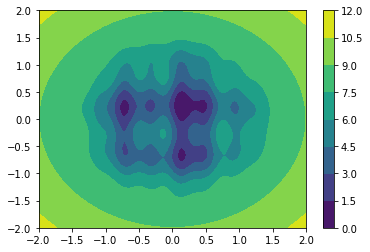

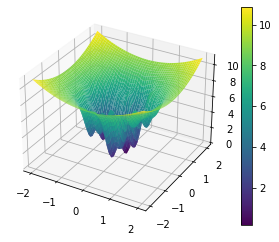

In [95]:
x = np.linspace(X_lower_boundary,X_upper_boundary,10**3)
y = np.linspace(Y_lower_boundary,Y_upper_boundary,10**3)

X,Y = np.meshgrid(x,y)

Z = beta*U(X,Y)
Z = Z - np.abs(np.min(Z))
Z = Z - np.min(Z)

plt.figure()
contourplot = plt.contourf(X,Y,Z)
plt.colorbar(contourplot)
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
surfaceplot = ax.plot_surface(X,Y,Z,cmap='viridis', edgecolor='none')
plt.colorbar(surfaceplot)
plt.show()


# Load all your functions here

In [96]:
def Langevine_dynamics(kT,
                       beta,
                       T,
                       X_equilibrium,
                       Y_equilibrium, 
                       X_lower_boundary, 
                       X_upper_boundary, 
                       Y_lower_boundary,
                       Y_upper_boundary,
                       force_constant_x, 
                       force_constant_y,
                       U,
                       grad_U_x,
                       grad_U_y,
                       tau,
                       X_current,
                       Y_current,
                       fric_coeff):
    
    import numpy as np
    
    U_biased = lambda x,y: U(x,y) +  force_constant_x*(x - X_equilibrium)**2 + force_constant_y*(y - Y_equilibrium)**2 
    grad_U_biased_x = lambda x,y: grad_U_x(x, y) +  2*force_constant_x*(x - X_equilibrium) 
    grad_U_biased_y = lambda x,y: grad_U_y(x, y) +  2*force_constant_y*(y - Y_equilibrium) 
    
    X_record = np.zeros(T)
    Y_record = np.zeros(T)
    E_record = np.zeros(T)
    
    E_current  = U_biased(X_current,Y_current)
    
    X_record[0] = X_current
    Y_record[0] = Y_current
    E_record[0] = E_current
    
    for i in range(1,T,1):
    
        mean = [X_current - tau*(1/fric_coeff)*grad_U_biased_x(X_current, Y_current),  Y_current - tau*(1/fric_coeff)*grad_U_biased_y(X_current, Y_current)]
        cov = ( 2*tau/(beta*fric_coeff) )*np.identity(2)
        X_new, Y_new = np.random.multivariate_normal(mean, cov, 1).T
    
        if X_new < X_lower_boundary or X_new > X_upper_boundary or Y_new < Y_lower_boundary or Y_new > Y_upper_boundary:
        
            X_record[i] = X_current
            Y_record[i] = Y_current
            E_record[i] = E_current
        
            continue
    
        else:
        
            E_new = U_biased(X_new,Y_new)
        
            X_record[i] = X_new
            Y_record[i] = Y_new
            E_record[i] = E_new
        
            E_current = E_new
            X_current = X_new[0]
            Y_current = Y_new[0]
            
            
    return [X_record, Y_record, E_record]

In [97]:
def MCMC_with_MH(kT,
                 beta,
                 T,
                 X_equilibrium,
                 Y_equilibrium, 
                 X_lower_boundary, 
                 X_upper_boundary, 
                 Y_lower_boundary,
                 Y_upper_boundary,
                 force_constant_x, 
                 force_constant_y,
                 U,
                 X_current,
                 Y_current):
    
    import numpy as np
    import random
    
    sigma = 0.055
    U_biased = lambda x,y: U(x,y) +  force_constant_x*(x - X_equilibrium)**2 + force_constant_y*(y - Y_equilibrium)**2 
   
    
    X_record = np.zeros(T)
    Y_record = np.zeros(T)
    E_record = np.zeros(T)
    
    E_current  = U_biased(X_current,Y_current)
    
    X_record[0] = X_current
    Y_record[0] = Y_current
    E_record[0] = E_current
    
    
    
    for i in range(1,T,1):
        
        X_new = X_current + sigma*np.random.normal(0,1,1)
        Y_new = Y_current + sigma*np.random.normal(0,1,1)
        
        if X_new < X_lower_boundary or X_new > X_upper_boundary or Y_new < Y_lower_boundary or Y_new > Y_upper_boundary:
            
            X_record[i] = X_current
            Y_record[i] = Y_current
            E_record[i] = E_current
            
            continue
        
        else:
            
            E_new = U_biased(X_new,Y_new)
            dE = E_new - E_current
            
            P = np.exp(-beta*dE)
            
            u = random.uniform(0, 1)
            
            if u <= min(1,P):
                
                E_current = E_new
                X_current = X_new
                Y_current = Y_new
                
            X_record[i] = X_current
            Y_record[i] = Y_current
            E_record[i] = E_current
            
    return [X_record, Y_record, E_record]


In [103]:
 def compute_bias(force_constant_x, force_constant_y, x, y, umbrella_centers):
    
    bias = force_constant_x*(x - umbrella_centers[0])**2 + force_constant_y*(y - umbrella_centers[1])**2
     
     
    return bias

# Initialize some parameters for umbrella sampling

In [104]:
#%% Set up umbrella sampling 

num_windows_per_dim = 6
force_constant_x = 10
force_constant_y = 10

X_window_boundaries = np.linspace(X_lower_boundary, X_upper_boundary, num = num_windows_per_dim+1)
X_equilibrium = X_window_boundaries[:-1] + 0.5*np.mean(np.diff(X_window_boundaries))


Y_window_boundaries = np.linspace(Y_lower_boundary, Y_upper_boundary, num = num_windows_per_dim+1)
Y_equilibrium = Y_window_boundaries[:-1] + 0.5*np.mean(np.diff(Y_window_boundaries))


umbrella_centers = np.zeros([1, 2])

for i in range(0,num_windows_per_dim,1):
    
    for j in range(0,num_windows_per_dim,1):
        
        umbrella_centers = np.vstack([umbrella_centers,[X_equilibrium[i], Y_equilibrium[j] ]])
    
umbrella_centers = np.delete(umbrella_centers, (0), axis=0)
umbrella_coordinates = np.sqrt(umbrella_centers[:,0]**2 + umbrella_centers[:,1]**2)

In [105]:
X_current = umbrella_centers[0,0]
Y_current = umbrella_centers[0,1]

X_record = np.zeros([num_windows_per_dim**2,T])
Y_record = np.zeros([num_windows_per_dim**2,T])
E_record = np.zeros([num_windows_per_dim**2,T])

if sampling_method == 'MCMC':
    
    print('Performing Umbrella sampling with MCMC')
    
    count = 0 
    for i in range(0,np.size(umbrella_centers,0),1):
        
        count = count + 1
        print('windows', count)
        
        [ X_record[i,:], Y_record[i,:], E_record[i,:] ] = MCMC_with_MH(kT,
                                                                         beta,
                                                                         T,
                                                                         umbrella_centers[i,0],
                                                                         umbrella_centers[i,1], 
                                                                         X_lower_boundary, 
                                                                         X_upper_boundary, 
                                                                         Y_lower_boundary,
                                                                         Y_upper_boundary,
                                                                         force_constant_x, 
                                                                         force_constant_y,
                                                                         U,
                                                                         X_current,
                                                                         Y_current)
        if i < np.size(umbrella_centers,0) - 1:
            
            sampled_X_states_so_far = (np.asanyarray(X_record)).flatten()
            sampled_Y_states_so_far = (np.asanyarray(Y_record)).flatten()
            sampled_states_so_far = np.sqrt(sampled_X_states_so_far**2 + sampled_Y_states_so_far**2)
              
              
            idx = (np.abs(sampled_states_so_far - umbrella_coordinates[i+1])).argmin() # index of the configuration closest to the center of next umbrella
            X_current = sampled_X_states_so_far[idx]
            Y_current = sampled_Y_states_so_far[idx]
            
        else:
            
            continue
            
else: # perform langevine dynamics
    
    print('Performing Umbrella sampling with langevine Dynamics')
    count = 0
    
    for i in range(0,np.size(umbrella_centers,0),1):
        
        count = count + 1
        print('windows', count)
        
        [ X_record[i,:], Y_record[i,:], E_record[i,:] ] = Langevine_dynamics(
                                                                            kT,
                                                                            beta,
                                                                            T,
                                                                            umbrella_centers[i,0], 
                                                                            umbrella_centers[i,1], 
                                                                            X_lower_boundary,
                                                                            X_upper_boundary,
                                                                            Y_lower_boundary,
                                                                            Y_upper_boundary, 
                                                                            force_constant_x, 
                                                                            force_constant_y, 
                                                                            U, 
                                                                            grad_U_x,
                                                                            grad_U_y,
                                                                            tau, 
                                                                            X_current, 
                                                                            Y_current,
                                                                            fric_coeff)
        
        if i < np.size(umbrella_centers,0) - 1:
                
                sampled_X_states_so_far = (np.asanyarray(X_record)).flatten()
                sampled_Y_states_so_far = (np.asanyarray(Y_record)).flatten()
                sampled_states_so_far = np.sqrt(sampled_X_states_so_far**2 + sampled_Y_states_so_far**2)
                
                idx = (np.abs(sampled_states_so_far - umbrella_coordinates[i+1])).argmin() # index of the configuration closest to the center of next umbrella
                X_current = sampled_X_states_so_far[idx]
                Y_current = sampled_Y_states_so_far[idx]
                
        else:
            
            continue
         
    

Performing Umbrella sampling with MCMC
windows 1
windows 2
windows 3
windows 4
windows 5
windows 6
windows 7
windows 8
windows 9
windows 10
windows 11
windows 12
windows 13
windows 14
windows 15
windows 16
windows 17
windows 18
windows 19
windows 20
windows 21
windows 22
windows 23
windows 24
windows 25
windows 26
windows 27
windows 28
windows 29
windows 30
windows 31
windows 32
windows 33
windows 34
windows 35
windows 36


# Visualize the trajectory of the agent in each umbrella.

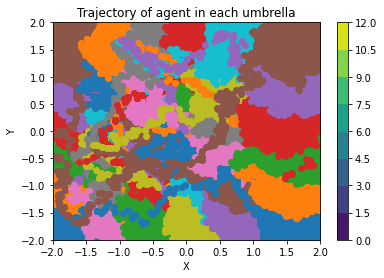

In [106]:
#%% Trajectory of agent in each umbrella

x = np.linspace(X_lower_boundary,X_upper_boundary,10**3)
y = np.linspace(Y_lower_boundary,Y_upper_boundary,10**3)

X,Y = np.meshgrid(x,y)

Z = beta*U(X,Y)
Z = Z - np.abs(np.min(Z))
Z = Z - np.min(Z)

plt.figure()
contourplot = plt.contourf(X,Y,Z)
plt.colorbar(contourplot)


for i in range(0,np.size(X_record,0),1):
    
    plt.scatter(X_record[i,:],Y_record[i,:])

plt.xlim([X_lower_boundary,X_upper_boundary])
plt.ylim([Y_lower_boundary,Y_upper_boundary])

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory of agent in each umbrella')
plt.show()

In [107]:
# Biased probability contour due to a given umbrella

<ipython-input-108-b3b7087619de>:9: RuntimeWarning: divide by zero encountered in log
  F = -np.log(values)-np.min(-np.log(values));


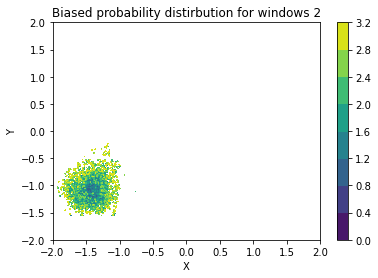

In [108]:
Num_Bins = 100
row = 1 # choose which umbella here
values, xedges, yedges = np.histogram2d(X_record[row,:], Y_record[row,:], bins=(Num_Bins,Num_Bins))
        
xcenters = (xedges[:-1] + xedges[1:])/2
ycenters = (yedges[:-1] + yedges[1:])/2

X,Y = np.meshgrid(xcenters,ycenters)
F = -np.log(values)-np.min(-np.log(values));

plt.figure()
contourplot = plt.contourf(X,Y,F)
plt.colorbar(contourplot)

plt.xlim([X_lower_boundary,X_upper_boundary])
plt.ylim([Y_lower_boundary,Y_upper_boundary])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Biased probability distirbution for windows ' + str(row +1))
plt.show()

# WEIGHTED HISTOGRAM ANALYSIS METHOD (WHAM)

 - Compute the F_i values

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196


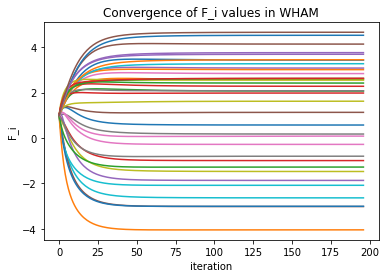

In [109]:
#%% Computing F_i values

beta = 1./kT
diff_threshold = 10**(-5)
diff = 10*diff_threshold

F_record = np.zeros([1, np.size(umbrella_centers,0)])
F = np.ones([1, np.size(umbrella_centers,0)])
F_record[0,:] = F

tt = 0

while diff > diff_threshold:
    
    tt = tt+1
    print(tt)
    
    bias = np.zeros([np.size(umbrella_centers,0), T])
    numerator = np.zeros([np.size(umbrella_centers,0), np.size(umbrella_centers,0), T])
    denominator = np.zeros([np.size(umbrella_centers,0), T])
    
    for kk in range(0,np.size(umbrella_centers,0),1):
        
        bias = compute_bias(force_constant_x, force_constant_y, X_record, Y_record, umbrella_centers[kk,:])
        numerator[kk,:,:] = np.exp(-beta*bias)
        
        denominator = denominator + T*np.exp(-beta*bias + beta*F[0][kk])
        
    arg = numerator/denominator
    arg = np.sum(np.sum(arg, axis = 2), axis=1) # sum across configurations and then sum across windows
    
    F = -kT*np.log([arg])
    
    F_record = np.vstack([F_record, F])
    
    diff = np.abs(np.max(F_record[tt,:] - F_record[tt-1,:]))


plt.figure()    
plt.plot(F_record) 
plt.xlabel('iteration')
plt.ylabel('F_i')
plt.title('Convergence of F_i values in WHAM')
plt.show()  

# Computing the unbiased probability distribution.

In [110]:
#%% Compute the un-Biased probability distribution

Num_Bins = 100
EDGES_X = np.linspace(X_lower_boundary, X_upper_boundary, num = Num_Bins+1)
EDGES_Y = np.linspace(Y_lower_boundary, Y_upper_boundary, num = Num_Bins+1)
beta = 1./kT
prob = np.zeros([Num_Bins, Num_Bins])

for i in range(1,np.size(EDGES_X),1):
    
    if i == np.size(EDGES_X):
        
        candidates_pos = np.where(( X_record >= EDGES_X[i-1] ) & ( X_record <= EDGES_X[i] ))
        
    else:
        
        candidates_pos = np.where(( X_record >= EDGES_X[i-1] ) & ( X_record < EDGES_X[i] ))
        
    if not list(candidates_pos[0]):
        
        print('Bin', 'X =', i-1, 'is empty')
        
        prob[i-1,:] = 0
        
        continue
    
    
    candidates_X = X_record[candidates_pos[0], candidates_pos[1]]
    candidates_Y = Y_record[candidates_pos[0], candidates_pos[1]] 
    
    for j in range(1,np.size(EDGES_Y),1):
        
        if j == np.size(EDGES_Y):
            
            candidates_pos_filter = np.where(( candidates_Y >= EDGES_Y[j-1] ) & ( candidates_Y <= EDGES_Y[j] ))
            
        else:
                
            candidates_pos_filter = np.where(( candidates_Y >= EDGES_Y[j-1] ) & ( candidates_Y < EDGES_Y[j] ))
            
        if not list(candidates_pos_filter[0]):
            
            print('Bin', 'X =', i-1, 'Y = ', j-1, 'is empty')
            
            prob[i-1,j-1] = 0
            
            continue
        
        else:
            
            Sum = 0
            for kk in range(0,np.size(candidates_pos_filter[0]),1):
            
                denom = 0
                for jj in range(0,np.size(umbrella_centers,0),1):
                    
                    bias = compute_bias(force_constant_x, force_constant_y, EDGES_X[i], EDGES_Y[j], umbrella_centers[jj,:])
                    denom = denom + T*np.exp(-beta*bias + beta*F[0][jj])
                    
                Sum = Sum + 1/denom
                
            prob[i-1,j-1] = Sum
            
prob = prob/np.sum(prob)

Bin X = 0 Y =  52 is empty
Bin X = 0 Y =  53 is empty
Bin X = 0 Y =  83 is empty
Bin X = 0 Y =  85 is empty
Bin X = 1 Y =  83 is empty
Bin X = 52 Y =  99 is empty
Bin X = 55 Y =  99 is empty
Bin X = 56 Y =  99 is empty
Bin X = 62 Y =  99 is empty
Bin X = 63 Y =  0 is empty
Bin X = 63 Y =  99 is empty
Bin X = 64 Y =  0 is empty
Bin X = 65 Y =  0 is empty
Bin X = 65 Y =  98 is empty
Bin X = 65 Y =  99 is empty
Bin X = 82 Y =  0 is empty
Bin X = 83 Y =  0 is empty
Bin X = 96 Y =  0 is empty
Bin X = 97 Y =  0 is empty
Bin X = 98 Y =  0 is empty
Bin X = 99 Y =  0 is empty
Bin X = 99 Y =  1 is empty
Bin X = 99 Y =  2 is empty
Bin X = 99 Y =  4 is empty
Bin X = 99 Y =  49 is empty
Bin X = 99 Y =  94 is empty


# Probability Contour plot 

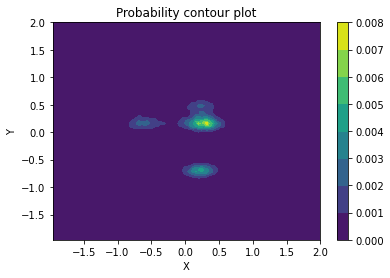

In [111]:
#%% probability contour plot                
            
x = EDGES_X[1:]
y = EDGES_Y[1:]

X,Y = np.meshgrid(x,y)

plt.figure()
contourplot = plt.contourf(X,Y,prob)
plt.colorbar(contourplot)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Probability contour plot')
plt.show() 

<ipython-input-112-8b42350fc1b8>:8: RuntimeWarning: divide by zero encountered in log
  F = -np.log(prob)-np.min(-np.log(prob))


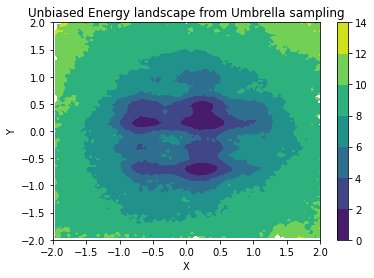

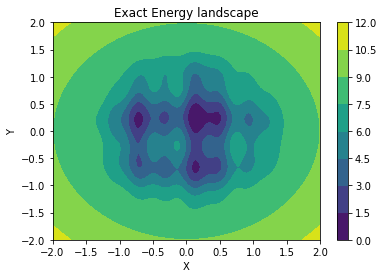

In [112]:
#%% Free energy plot                
            
x = EDGES_X[1:]
y = EDGES_Y[1:]

X,Y = np.meshgrid(x,y)

F = -np.log(prob)-np.min(-np.log(prob))

plt.figure()
contourplot = plt.contourf(X,Y,F)
plt.colorbar(contourplot)
plt.xlim([X_lower_boundary, X_upper_boundary])
plt.ylim([Y_lower_boundary, Y_upper_boundary]) 
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Unbiased Energy landscape from Umbrella sampling')
plt.show()


# True free energy landscape
plt.figure()
x = np.linspace(X_lower_boundary,X_upper_boundary,10**3)
y = np.linspace(Y_lower_boundary,Y_upper_boundary,10**3)

X,Y = np.meshgrid(x,y)

Z = beta*U(X,Y)
Z = Z - np.abs(np.min(Z))
Z = Z - np.min(Z)

contourplot = plt.contourf(X,Y,Z)
plt.colorbar(contourplot)
plt.xlim([X_lower_boundary, X_upper_boundary])
plt.ylim([Y_lower_boundary, Y_upper_boundary])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exact Energy landscape')
plt.show()